In [1]:
# COMP 4220 Machine Learning
# Michelle Ly
# Final Project: CORD-19

!uname -a

Darwin Michelles-MacBook-Air-3.local 23.3.0 Darwin Kernel Version 23.3.0: Wed Dec 20 21:30:27 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T8103 arm64


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import gensim.corpora as corpora
import gensim
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [3]:
# Data from https://www.kaggle.com/datasets/googleai/dataset-metadata-for-cord19/data
df = pd.read_csv('CORD19_datasets.csv')

In [4]:
# Examine dataframe
df[:10]

,cord_uid,paper_url,paper_title,dataset_url,dataset_name,alternate_name,description,author_list,last_updated,license,source_organization,doi,compact_identifier,data_download
0,rmzpiyqj,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"Nipah virus: epidemiology, pathology, immunobi...",https://data.csiro.au/dap/landingpage?pid=csir...,Nature of exposure drives transmission of Nipa...,NaN,"[""RT-PCR data of comparative viral loads/ tiss...",Bronwyn Clayton; Deborah Middleton; Rachel Ark...,2016,"[{""url"":""https://confluence.csiro.au/display/d...",CSIRO,10.4225/08/56806AAEAD713,NaN,NaN
1,h7g5ecc0,http://europepmc.org/articles/pmc4052367?pdf=r...,Novel approaches and challenges to treatment o...,https://datamed.org/display-item.php?repositor...,Key Role of T cell Defects in Age-Related Vuln...,NaN,"[""In a mouse model of age-related vulnerabilit...",NaN,2019-05-06,NaN,NaN,NaN,NaN,NaN
2,3uvlmww0,https://jvi.asm.org/content/jvi/88/17/10228.fu...,"Verdinexor, a Novel Selective Inhibitor of Nuc...",https://datamed.org/display-item.php?repositor...,MicroRNA Regulation of Human Protease Genes,NaN,the human protease genes required for influenz...,NaN,2011-10-13,NaN,NaN,NaN,NaN,NaN
3,xzps65et,https://doi.org/10.14745/ccdr.v45i04a01,Climate change and infectious diseases: What c...,https://search.datacite.org/works/10.5065/d6sj...,The NA-CORDEX dataset,NaN,"[""The NA-CORDEX data archive contains output f...",Linda Mearns; Seth McGinnis; Daniel Korytina; ...,2017,"[{""url"":""http://na-cordex.org/terms-use""}]",UCAR/NCAR,10.5065/d6sj1jch,NaN,NaN
4,a6p8te8q,https://jvi.asm.org/content/jvi/79/6/3370.full...,Increased Epitope-Specific CD8(+) T Cells Prev...,http://www.immunedata.org/display-item.php?rep...,CMV CD8 T Cells,NaN,"[""We present human T cell responses in multipl...",NaN,2018-09-17,NaN,NaN,NaN,NaN,NaN
5,qpwvqdlc,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Natural Killer Cell Sensing of Infected Cells ...,http://www.immunedata.org/display-item.php?rep...,CMV CD8 T Cells,NaN,"[""We present human T cell responses in multipl...",NaN,2018-09-17,NaN,NaN,NaN,NaN,NaN
6,1udcd28n,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,Role of Natural Killer and Gamma-Delta T cells...,https://datamed.org/display-item.php?repositor...,Key Role of T cell Defects in Age-Related Vuln...,NaN,In a mouse model of age-related vulnerability ...,NaN,2019-05-06,NaN,NaN,NaN,NaN,NaN
7,00mqmpzw,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,The C-Terminal Effector Domain of Non-Structur...,https://www.omicsdi.org/dataset/omics_ena_proj...,Influenza A virus strain:A/Puerto Rico/8/1934(...,NaN,Influenza A virus strain:A/Puerto Rico/8/1934(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,00mqmpzw,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,The C-Terminal Effector Domain of Non-Structur...,https://plos.figshare.com/articles/Species_Spe...,Species-Specific Inhibition of RIG-I Ubiquitin...,NaN,Influenza A viruses can adapt to new host spec...,Ricardo Rajsbaum; Randy A. Albrecht; May K. Wa...,2016-01-19,"[{""text"":""Attribution 4.0 International (CC BY...",PLOS Pathogens,10.1371/journal.ppat.1003059,NaN,"[{""download_url"":""https://plos.figshare.com/nd..."
9,00mqmpzw,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,The C-Terminal Effector Domain of Non-Structur...,https://plos.figshare.com/articles/Proteomic_P...,Proteomic Profiling of the TRAF3 Interactome N...,NaN,Tumor Necrosis Factor receptor-associated fact...,Wendy J. van Zuylen; Priscilla Doyon; Jean-Fra...,2016-01-19,"[{""text"":""Attribution 4.0 International (CC BY...",PLOS Pathogens,10.1371/journal.ppat.1002747,NaN,"[{""download_url"":""https://plos.figshare.com/nd..."


In [5]:
df.shape

(16070, 14)

In [6]:
# Focus on paper title and description
text_columns = ['paper_title', 'dataset_name', 'description']
df_text = df[text_columns]
df_text[:10]

,paper_title,dataset_name,description
0,"Nipah virus: epidemiology, pathology, immunobi...",Nature of exposure drives transmission of Nipa...,"[""RT-PCR data of comparative viral loads/ tiss..."
1,Novel approaches and challenges to treatment o...,Key Role of T cell Defects in Age-Related Vuln...,"[""In a mouse model of age-related vulnerabilit..."
2,"Verdinexor, a Novel Selective Inhibitor of Nuc...",MicroRNA Regulation of Human Protease Genes,the human protease genes required for influenz...
3,Climate change and infectious diseases: What c...,The NA-CORDEX dataset,"[""The NA-CORDEX data archive contains output f..."
4,Increased Epitope-Specific CD8(+) T Cells Prev...,CMV CD8 T Cells,"[""We present human T cell responses in multipl..."
5,Natural Killer Cell Sensing of Infected Cells ...,CMV CD8 T Cells,"[""We present human T cell responses in multipl..."
6,Role of Natural Killer and Gamma-Delta T cells...,Key Role of T cell Defects in Age-Related Vuln...,In a mouse model of age-related vulnerability ...
7,The C-Terminal Effector Domain of Non-Structur...,Influenza A virus strain:A/Puerto Rico/8/1934(...,Influenza A virus strain:A/Puerto Rico/8/1934(...
8,The C-Terminal Effector Domain of Non-Structur...,Species-Specific Inhibition of RIG-I Ubiquitin...,Influenza A viruses can adapt to new host spec...
9,The C-Terminal Effector Domain of Non-Structur...,Proteomic Profiling of the TRAF3 Interactome N...,Tumor Necrosis Factor receptor-associated fact...


In [7]:
df_text.shape

(16070, 3)

In [8]:
# Check null type
df_text.isna().sum()

paper_title        0
dataset_name       0
description     1944
dtype: int64

In [9]:
# Replace null values with empty string
df_text['description'] = df_text['description'].fillna('')
df_text.isna().sum()

/var/folders/kg/z74bmd316b79f5qc7z62rklc0000gn/T/ipykernel_28186/79292757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['description'] = df_text['description'].fillna('')


paper_title     0
dataset_name    0
description     0
dtype: int64

In [10]:
# Check types
print(type(df_text['paper_title'][0]))
print(type(df_text['dataset_name'][0]))
print(type(df_text['description'][0]))

<class 'str'>
<class 'str'>
<class 'str'>


In [11]:
# Check duplicates
print("Duplicate paper_title: ", df_text.duplicated(subset=['paper_title']).sum())
print("Duplicate dataset_name: ", df_text.duplicated(subset=['dataset_name']).sum())
print("Duplicate description: ", df_text.duplicated(subset=['description']).sum())

Duplicate paper_title:  12046
Duplicate dataset_name:  7292
Duplicate description:  5833


In [12]:
# View top 10 referenced paper titles
top_10_papers = df_text['paper_title'].value_counts().head(10)
top_10_papers

paper_title
Whole transcriptome analysis of the ERα synthetic fragment P(295)‐T311 (ERα17p) identifies specific ERα‐isoform (ERα, ERα36)‐dependent and ‐independent actions in breast cancer cells    291
The Use of Kosher Phenotyping for Mapping QTL Affecting Susceptibility to Bovine Respiratory Disease                                                                                      160
The potential of the human immune system to develop broadly neutralizing HIV-1 antibodies: implications for vaccine development                                                           145
Reactomes of Porcine Alveolar Macrophages Infected with Porcine Reproductive and Respiratory Syndrome Virus                                                                               142
Positive selection of the TRIM family regulatory region in primate genomes                                                                                                                122
Host-Virus Protein Interaction Network

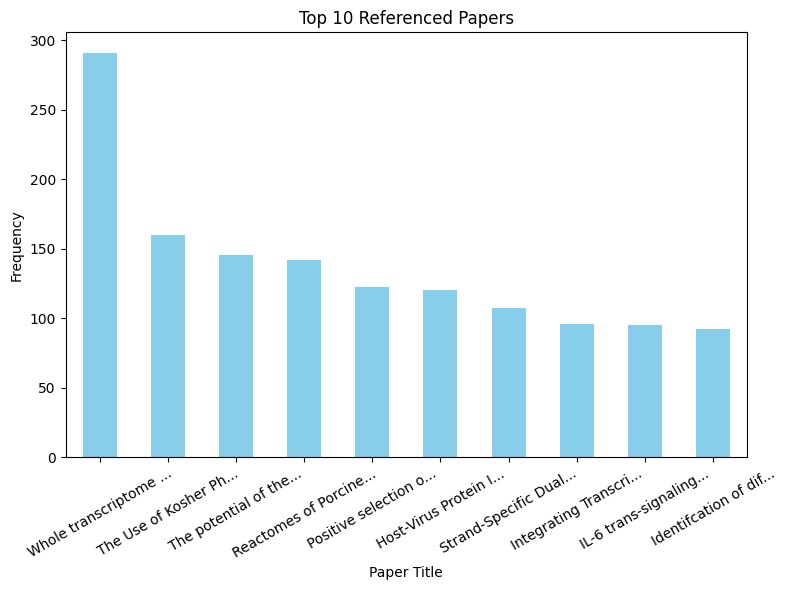

In [14]:
# Plot top 10 referenced paper titles
plt.figure(figsize=(8, 6))
# Shorten labels
short_title_labels = [label[:20] + '...' if len(label) > 20 else label for label in top_10_papers.index]
top_10_papers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Referenced Papers')
plt.xlabel('Paper Title')
plt.xticks(range(len(short_title_labels)), short_title_labels, rotation = 30)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
# View top 10 referenced dataset names
top_10_dataset_names = df_text['dataset_name'].value_counts().head(10)
top_10_dataset_names

dataset_name
Leader Protease                                                                                               56
DHX33                                                                                                         40
IFITM10                                                                                                       38
Ifitm10                                                                                                       38
Data from: Neuraminidase inhibitors for preventing and treating influenza in healthy adults and children      33
TRIM38                                                                                                        27
IFNA5                                                                                                         27
SARS-Coronavirus Replication Is Supported by a Reticulovesicular Network of Modified Endoplasmic Reticulum    25
Distinct Patterns of IFITM-Mediated Restriction of Filoviruses, SARS Coronavirus, a

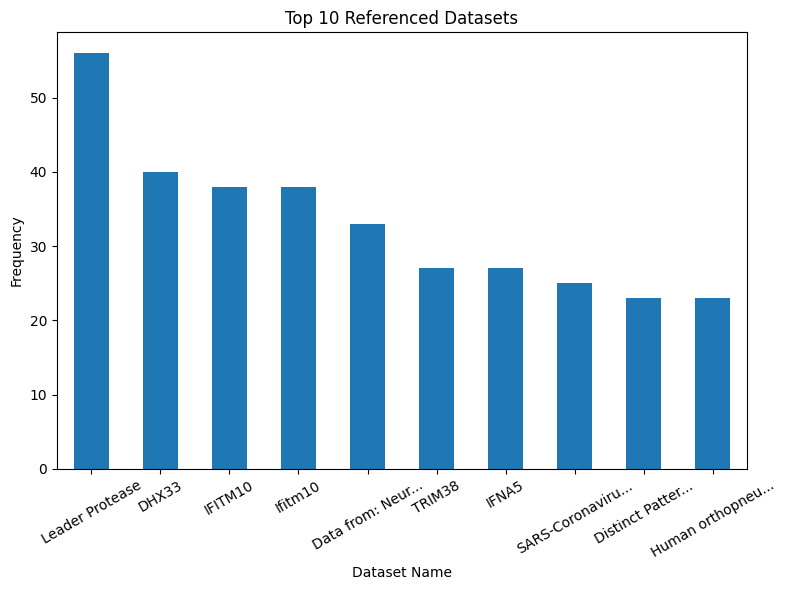

In [16]:
# Plot top 10 referenced paper titles
plt.figure(figsize=(8, 6))
# Shorten labels
short_dataset_labels = [label[:15] + '...' if len(label) > 15 else label for label in top_10_dataset_names.index]
top_10_dataset_names.plot(kind='bar')
plt.title('Top 10 Referenced Datasets')
plt.xlabel('Dataset Name')
plt.xticks(range(len(short_dataset_labels)), short_dataset_labels, rotation = 30)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [17]:
# Separate into different dataframes and drop duplicates
df_paper_title = pd.DataFrame(df_text['paper_title'].drop_duplicates())
df_dataset_name = pd.DataFrame(df_text['dataset_name'].drop_duplicates())
df_description = pd.DataFrame(df_text['description'].drop_duplicates())

In [18]:
print(len(df_paper_title))
df_paper_title[:5]

4024


,paper_title
0,"Nipah virus: epidemiology, pathology, immunobi..."
1,Novel approaches and challenges to treatment o...
2,"Verdinexor, a Novel Selective Inhibitor of Nuc..."
3,Climate change and infectious diseases: What c...
4,Increased Epitope-Specific CD8(+) T Cells Prev...


In [19]:
print(len(df_dataset_name))
df_dataset_name[:5]

8778


,dataset_name
0,Nature of exposure drives transmission of Nipa...
1,Key Role of T cell Defects in Age-Related Vuln...
2,MicroRNA Regulation of Human Protease Genes
3,The NA-CORDEX dataset
4,CMV CD8 T Cells


In [20]:
print(len(df_description))
df_description[:5]

10237


,description
0,"[""RT-PCR data of comparative viral loads/ tiss..."
1,"[""In a mouse model of age-related vulnerabilit..."
2,the human protease genes required for influenz...
3,"[""The NA-CORDEX data archive contains output f..."
4,"[""We present human T cell responses in multipl..."


In [21]:
# Regex and stop words
remove_punctuation = re.compile(r"[^0-9A-Za-z -]")
stop_words = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

# Preprocess and clean data
def preprocess_data(text):
    # Convert text to lowercase and remove all non alphanumeric, dash, or space characters with regex
    text = text.lower()
    text = re.sub(remove_punctuation, "", text)
    text = wordnet_lemmatizer.lemmatize(text)
    
    # Convert into array and remove stop words
    text_arr = text.split()
    text_arr = [word for word in text_arr if word not in stop_words]
    return text_arr

df_paper_title['paper_title'] = df_paper_title['paper_title'].apply(preprocess_data)
df_dataset_name['dataset_name'] = df_dataset_name['dataset_name'].apply(preprocess_data)
df_description['description'] = df_description['description'].apply(preprocess_data)

In [22]:
df_paper_title[:5]

,paper_title
0,"[nipah, virus, epidemiology, pathology, immuno..."
1,"[novel, approaches, challenges, treatment, cns..."
2,"[verdinexor, novel, selective, inhibitor, nucl..."
3,"[climate, change, infectious, diseases, expect]"
4,"[increased, epitope-specific, cd8, cells, prev..."


In [23]:
df_dataset_name[:5]

,dataset_name
0,"[nature, exposure, drives, transmission, nipah..."
1,"[key, role, cell, defects, age-related, vulner..."
2,"[microrna, regulation, human, protease, genes]"
3,"[na-cordex, dataset]"
4,"[cmv, cd8, cells]"


In [24]:
df_description[:5]

,description
0,"[rt-pcr, data, comparative, viral, loads, tiss..."
1,"[mouse, model, age-related, vulnerability, wnv..."
2,"[human, protease, genes, required, influenza, ..."
3,"[na-cordex, data, archive, contains, output, r..."
4,"[present, human, cell, responses, multiple, si..."


In [25]:
# Define function to generate word cloud
def generate_WordCloud(string, color, name):
    wordcloud = WordCloud(background_color = "white", max_words = 100, contour_width = 3, colormap = color, repeat = False)
    wordcloud.generate(string)
    wordcloud.to_file(name + ".png")
    return wordcloud.to_image()

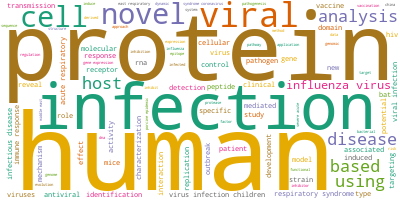

In [26]:
# Convert paper titles to one string
paper_titles = ', '.join([' '.join(lst) for lst in df_paper_title['paper_title'].values])
# Generate word cloud
generate_WordCloud(paper_titles, 'Dark2', 'paper_title_wordcloud')

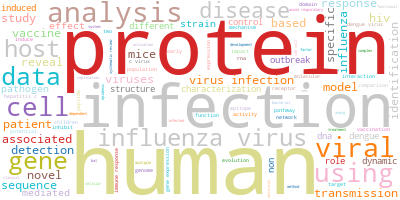

In [27]:
# Convert dataset names to one string
dataset_names = ', '.join([' '.join(lst) for lst in df_dataset_name['dataset_name'].values])
# Generate word cloud
generate_WordCloud(dataset_names, 'tab20', 'dataset_name_wordcloud')

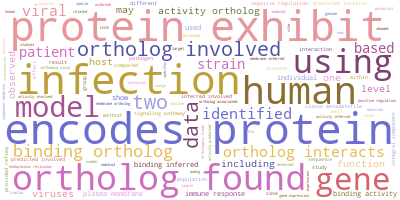

In [28]:
# Convert descriptions to one string
descriptions = ', '.join([' '.join(lst) for lst in df_description['description'].values])
# Generate word cloud
generate_WordCloud(descriptions, 'tab20b', 'description_wordcloud')

In [29]:
# Create dictionary, corpus, and frequency for paper titles
id2word_paper_title = corpora.Dictionary(df_paper_title['paper_title'])
texts_paper_title = df_paper_title['paper_title']
corpus_paper_title = [id2word_paper_title.doc2bow(text) for text in texts_paper_title]
print(corpus_paper_title[:5])

# Create dictionary, corpus, and frequency for dataset names
id2word_dataset_name = corpora.Dictionary(df_dataset_name['dataset_name'])
texts_dataset_name = df_dataset_name['dataset_name']
corpus_dataset_name = [id2word_dataset_name.doc2bow(text) for text in texts_dataset_name]
print(corpus_dataset_name[:5])

# Create dictionary, corpus, and frequency for descriptions
id2word_description = corpora.Dictionary(df_description['description'])
texts_description = df_description['description']
corpus_description = [id2word_description.doc2bow(text) for text in texts_description]
print(corpus_description[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(12, 1), (17, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(7, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1

In [30]:
# Focus on 5 topics
topic_num = 5
# Build LDA model for paper titles
lda_model_paper_title = gensim.models.LdaMulticore(corpus = corpus_paper_title, id2word = id2word_paper_title, num_topics = topic_num)
pprint(lda_model_paper_title.print_topics())

[(0,
  '0.017*"virus" + 0.007*"influenza" + 0.006*"protein" + 0.006*"novel" + '
  '0.006*"infectious" + 0.005*"viral" + 0.005*"cells" + 0.005*"viruses" + '
  '0.005*"human" + 0.004*"infection"'),
 (1,
  '0.015*"virus" + 0.011*"human" + 0.011*"respiratory" + 0.011*"infection" + '
  '0.011*"cells" + 0.010*"protein" + 0.008*"viruses" + 0.007*"influenza" + '
  '0.007*"coronavirus" + 0.007*"viral"'),
 (2,
  '0.021*"virus" + 0.009*"influenza" + 0.009*"viral" + 0.007*"infection" + '
  '0.005*"analysis" + 0.005*"response" + 0.005*"using" + 0.005*"immune" + '
  '0.005*"protein" + 0.005*"coronavirus"'),
 (3,
  '0.021*"virus" + 0.012*"respiratory" + 0.009*"viral" + 0.006*"infections" + '
  '0.006*"human" + 0.005*"rna" + 0.005*"disease" + 0.005*"detection" + '
  '0.005*"analysis" + 0.004*"novel"'),
 (4,
  '0.014*"virus" + 0.012*"infection" + 0.009*"respiratory" + 0.007*"influenza" '
  '+ 0.007*"human" + 0.006*"protein" + 0.005*"analysis" + 0.005*"coronavirus" '
  '+ 0.005*"disease" + 0.004*"cell"'

In [31]:
# LDA topic modelling for paper titles
pyLDAvis.enable_notebook()
LDAvis_prepared_paper_title = pyLDAvis.gensim.prepare(lda_model_paper_title, corpus_paper_title, id2word_paper_title)
# Save visualization in HTML
pyLDAvis.save_html(LDAvis_prepared_paper_title, 'paper_title_topics.html')
# Display visualization
LDAvis_prepared_paper_title

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002143  0.042752       1        1  27.098801
4     -0.021429  0.044016       2        1  18.837016
2      0.041676  0.017675       3        1  18.345137
3     -0.075362 -0.044007       4        1  17.917188
0      0.052973 -0.060435       5        1  17.801858, topic_info=            Term        Freq       Total Category  logprob  loglift
309  respiratory  309.000000  309.000000  Default  30.0000  30.0000
36         cells  209.000000  209.000000  Default  29.0000  29.0000
61     infection  314.000000  314.000000  Default  28.0000  28.0000
148    detection   99.000000   99.000000  Default  27.0000  27.0000
16    infections  108.000000  108.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
38   coronavirus   25.556585  201.393937   Topic5  -5.6542  -0.3385
83       disease   23.076664  183.654088   Topic5  -5.7562  -0.3484
282         host   18.995578  119.231181   Topic5  -5.9508  -0.1110
251        study   17.437943   89.065430   Topic5  -6.0364   0.0951
48          cell   17.638310  128.313711   Topic5  -6.0250  -0.2585

[443 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
65        1  0.216739        1
65        2  0.270924        1
65        3  0.126431        1
65        4  0.307047        1
65        5  0.072246        1
...     ...       ...      ...
1474      1  0.123451  without
1474      2  0.123451  without
1474      3  0.123451  without
1474      4  0.617253  without
2084      4  0.823917  zealand

[912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

In [32]:
# Build LDA model for dataset names
lda_model_dataset_name = gensim.models.LdaMulticore(corpus = corpus_dataset_name, id2word = id2word_dataset_name, num_topics = topic_num)
pprint(lda_model_dataset_name.print_topics())

[(0,
  '0.013*"virus" + 0.007*"influenza" + 0.007*"infection" + 0.005*"analysis" + '
  '0.005*"novel" + 0.005*"human" + 0.005*"cells" + 0.004*"using" + '
  '0.004*"patients" + 0.004*"immune"'),
 (1,
  '0.020*"virus" + 0.011*"infection" + 0.010*"influenza" + 0.009*"analysis" + '
  '0.007*"human" + 0.007*"cells" + 0.007*"disease" + 0.005*"gene" + '
  '0.005*"cell" + 0.005*"expression"'),
 (2,
  '0.012*"human" + 0.010*"virus" + 0.006*"protein" + 0.005*"rna" + '
  '0.004*"respiratory" + 0.004*"infection" + 0.004*"viruses" + '
  '0.003*"infections" + 0.003*"influenza" + 0.003*"responses"'),
 (3,
  '0.012*"viral" + 0.008*"virus" + 0.006*"human" + 0.006*"influenza" + '
  '0.006*"infection" + 0.005*"respiratory" + 0.005*"acute" + 0.004*"cells" + '
  '0.004*"protein" + 0.004*"study"'),
 (4,
  '0.015*"virus" + 0.006*"influenza" + 0.005*"protein" + 0.004*"cells" + '
  '0.004*"viruses" + 0.004*"cell" + 0.004*"disease" + 0.003*"replication" + '
  '0.003*"rna" + 0.003*"infection"')]


In [33]:
# LDA topic modelling for dataset names
pyLDAvis.enable_notebook()
LDAvis_prepared_dataset_name = pyLDAvis.gensim.prepare(lda_model_dataset_name, corpus_dataset_name, id2word_dataset_name)
# Save visualization in HTML
pyLDAvis.save_html(LDAvis_prepared_dataset_name, 'dataset_name_topics.html')
# Display visualization
LDAvis_prepared_dataset_name

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.042862 -0.013296       1        1  28.952091
3     -0.023656 -0.083108       2        1  18.579470
0     -0.029110  0.046762       3        1  17.821473
4      0.067353  0.022572       4        1  17.442219
2     -0.057450  0.027070       5        1  17.204747, topic_info=         Term        Freq       Total Category  logprob  loglift
179     viral  258.000000  258.000000  Default  30.0000  30.0000
19      human  399.000000  399.000000  Default  29.0000  29.0000
111  analysis  266.000000  266.000000  Default  28.0000  28.0000
707      type   92.000000   92.000000  Default  27.0000  27.0000
165       rna  154.000000  154.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
55    disease   24.425183  218.526439   Topic5  -6.0339  -0.4313
179     viral   24.893442  258.592316   Topic5  -6.0149  -0.5807
10       cell   23.509145  220.858671   Topic5  -6.0721  -0.4801
111  analysis   23.009678  266.700506   Topic5  -6.0936  -0.6902
26      cells   20.563071  282.336524   Topic5  -6.2060  -0.8596

[439 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
470        1  0.071019        1
470        2  0.454519        1
470        3  0.099426        1
470        4  0.099426        1
470        5  0.255667        1
...      ...       ...      ...
6766       3  0.631495  zdhhc13
12493      5  0.634571   zdhhc7
688        1  0.422479     zika
688        3  0.422479     zika
688        4  0.132025     zika

[909 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [34]:
# Build LDA model for descriptions
lda_model_description = gensim.models.LdaMulticore(corpus = corpus_description, id2word = id2word_description, num_topics = topic_num)
pprint(lda_model_description.print_topics())

[(0,
  '0.016*"inferred" + 0.012*"ortholog" + 0.009*"protein" + 0.006*"involved" + '
  '0.006*"activity" + 0.006*"found" + 0.005*"associated" + 0.005*"virus" + '
  '0.005*"rna" + 0.004*"viral"'),
 (1,
  '0.005*"cells" + 0.004*"study" + 0.004*"protein" + 0.004*"infection" + '
  '0.004*"ortholog" + 0.004*"involved" + 0.004*"human" + 0.004*"virus" + '
  '0.003*"cell" + 0.003*"influenza"'),
 (2,
  '0.023*"ortholog" + 0.011*"protein" + 0.008*"activity" + 0.006*"binding" + '
  '0.006*"virus" + 0.006*"involved" + 0.006*"cells" + 0.005*"infection" + '
  '0.005*"associated" + 0.004*"found"'),
 (3,
  '0.015*"ortholog" + 0.013*"protein" + 0.007*"involved" + 0.007*"found" + '
  '0.005*"activity" + 0.005*"virus" + 0.005*"binding" + 0.005*"viral" + '
  '0.004*"gene" + 0.004*"pathway"'),
 (4,
  '0.007*"virus" + 0.006*"infection" + 0.005*"protein" + 0.004*"viral" + '
  '0.004*"cells" + 0.004*"human" + 0.004*"gene" + 0.004*"data" + 0.003*"cell" '
  '+ 0.003*"also"')]


In [35]:
# LDA topic modelling for description
pyLDAvis.enable_notebook()
LDAvis_prepared_description = pyLDAvis.gensim.prepare(lda_model_description, corpus_description, id2word_description)
# Save visualization in HTML
pyLDAvis.save_html(LDAvis_prepared_description, 'description_topics.html')
# Display visualization
LDAvis_prepared_description

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.025573 -0.012646       1        1  29.158577
2     -0.016600 -0.005739       2        1  21.382824
1      0.016431  0.014632       3        1  20.950672
3     -0.014437 -0.008312       4        1  14.398651
0     -0.010966  0.012065       5        1  14.109276, topic_info=             Term         Freq        Total Category  logprob  loglift
273      ortholog  8316.000000  8316.000000  Default  30.0000  30.0000
1197     inferred  3463.000000  3463.000000  Default  29.0000  29.0000
280       protein  6682.000000  6682.000000  Default  28.0000  28.0000
740      involved  3848.000000  3848.000000  Default  27.0000  27.0000
238         found  3507.000000  3507.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
134   replication   242.337545  1415.060399   Topic5  -6.2052   0.1937
39          cells   430.560902  3682.882219   Topic5  -5.6304  -0.1880
254     interacts   285.686957  1938.848327   Topic5  -6.0406   0.0434
676     predicted   282.113687  2229.778842   Topic5  -6.0532  -0.1090
351          gene   319.925036  3121.169935   Topic5  -5.9274  -0.3195

[476 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
1474       3  0.812404             -336g
1474       4  0.101551             -336g
6748       1  0.767721  12045206supplied
46746      5  0.440596        129s1svimj
10511      4  0.838738              1394
...      ...       ...               ...
8597       1  0.592566         zanamivir
8597       2  0.120611         zanamivir
8597       3  0.104879         zanamivir
8597       4  0.120611         zanamivir
8597       5  0.062927         zanamivir

[1099 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])